In [56]:
import pandas as pd
from PIL.ImageOps import scale
from numpy.ma.extras import stack

from sklearn.metrics import confusion_matrix # 混合行列
from sklearn.model_selection import train_test_split

# 図やグラフを図示するためのライブラリをインポートする。
%matplotlib inline
import matplotlib.pyplot as plt

import optuna

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA #主成分分析
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier # K近傍法
from sklearn.svm import SVC # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from lightgbm import LGBMClassifier #LGBM
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.naive_bayes import GaussianNB # ナイーブ・ベイズ



In [23]:
# データの読み込み
data = pd.read_csv('../../data/preprocessed_data.csv')

# 特徴量とターゲット変数の分割
X = data.drop('dengue', axis=1)  
y = data['dengue']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
#最適化したハイパーパラメータの表示
best_params_df=pd.read_csv('best_params/best_hyperparameters_2.csv')
best_params_df

,Unnamed: 0,solver,C,n_neighbors,weights,algorithm,gamma,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,num_leaves,learning_rate,lambda_l1,lambda_l2,var_smoothing
0,Logistic Regression,liblinear,0.090481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SVM RBF,NaN,3.999592,NaN,NaN,NaN,auto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KNN,NaN,NaN,38.0,uniform,auto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Decision Tree,NaN,NaN,NaN,NaN,NaN,NaN,gini,35.0,52.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Random Forest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,49.0,58.0,541.0,NaN,NaN,NaN,NaN,NaN
5,LGBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.0,476.0,0.001029,43.872091,38.401821,NaN
6,AdaBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,NaN,0.247280,NaN,NaN,NaN
7,Naive Bayes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.684930e-08


最適化ハイパーパラメータ

In [37]:
names = ["Logistic Regression", "Nearest Neighbors", "RBF SVM", 
         "Decision Tree","Random Forest","LGBM","AdaBoost", "Naive Bayes"]

classifiers = [
    LogisticRegression(solver='liblinear',penalty='l2',C=0.090481,class_weight='balanced'),
    SVC(kernel="rbf",C=3.999592,gamma='auto',class_weight='balanced',probability=True),
    KNeighborsClassifier(n_neighbors=38,weights='uniform',algorithm='auto'),
    DecisionTreeClassifier(criterion='gini',max_depth=35,min_samples_split=52,min_samples_leaf=92,class_weight='balanced'),
    RandomForestClassifier(max_depth=65,min_samples_split=49,min_samples_leaf=58,n_estimators=541,class_weight='balanced'),
    LGBMClassifier(n_estimators=243,num_leaves=476,learning_rate=0.001029,lambda_l1=43.872091,lambda_l2=38.401821,class_weight='balanced'),
    AdaBoostClassifier(algorithm='SAMME',n_estimators=168,learning_rate=0.247280),
    GaussianNB(var_smoothing=5.684930e-08)]

In [38]:
result = []
for name, clf in zip(names, classifiers): # 指定した複数の分類機を順番に呼び出す
    clf.fit(X_train, y_train) # 学習
    score1 = clf.score(X_train, y_train) # 正解率（train）の算出
    score2 = clf.score(X_test, y_test) # 正解率（test）の算出
    result.append([score1, score2]) # 結果の格納

# test の正解率の大きい順に並べる
result = pd.DataFrame(result, columns=['train', 'test'], index=names).sort_values('test', ascending=False)


[LightGBM] [Warning] lambda_l2 is set=38.401821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.401821
[LightGBM] [Warning] lambda_l1 is set=43.872091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=43.872091
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=38.401821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.401821
[LightGBM] [Warning] lambda_l1 is set=43.872091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=43.872091
[LightGBM] [Info] Number of positive: 1345, number of negative: 1725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 3070, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScor

<Axes: >

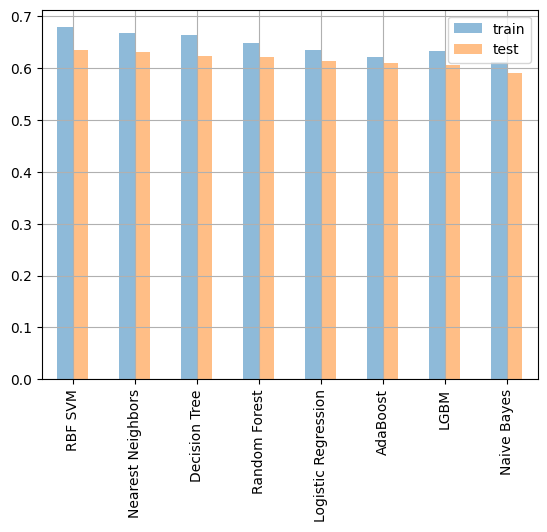

In [39]:
 #棒グラフの描画
result.plot(kind='bar', alpha=0.5, grid=True)


スタッキング

スタッキングモデルの最適化

In [53]:
def object_stacking(trial):
    # 使用するモデル名と分類器を定義
    names = ["Logistic Regression", "Nearest Neighbors", "RBF SVM", "Decision Tree", "Random Forest"]

    classifiers = [LogisticRegression(solver='liblinear',penalty='l2',C=0.090481,class_weight='balanced'),
                   SVC(kernel="rbf",C=3.999592,gamma='auto',class_weight='balanced',probability=True),
                   KNeighborsClassifier(n_neighbors=38,weights='uniform',algorithm='auto'),
                   DecisionTreeClassifier(criterion='gini',max_depth=35,min_samples_split=52,min_samples_leaf=92,class_weight='balanced'),
                   RandomForestClassifier(max_depth=65,min_samples_split=49,min_samples_leaf=58,n_estimators=541,class_weight='balanced')
                   ]

    # 弱分類機
    estimators = [(name, clf) for name, clf in zip(names, classifiers)]

    # メタモデル
    num_leaves = trial.suggest_int('num_leaves', 10, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    lambda_l1=trial.suggest_float('lambda_l1', 0.0001, 100)
    lambda_l2=trial.suggest_float('lambda_l2', 0.0001, 100)
    meta_model = LGBMClassifier(num_leaves=num_leaves,
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                lambda_l1=lambda_l1,
                                lambda_l2=lambda_l2,
                                class_weight='balanced')

    # スタッキングの定義
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model)
    
    score = cross_val_score(stacking_clf, X_train, y_train, cv=3).mean()
    
    return  score



[LightGBM] [Info] Number of positive: 1345, number of negative: 1725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 3070, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Ensemble Model Accuracy: 0.6071


In [ ]:
# Optunaによる最適化の実行
study = optuna.create_study(direction='maximize')
study.optimize(object_stacking, n_trials=50)

# 最適なハイパーパラメータを表示
print("Best parameters: ", study.best_params)

In [ ]:
# 予測
y_pred = stacking_clf.predict(X_test)

# 精度の表示
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")


#可視化の準備
stacking_score1 = stacking_clf.score(X_train, y_train)  
stacking_score2 = stacking_clf.score(X_test, y_test)    

# スタッキング結果を DataFrame に追加
stacking_result = pd.DataFrame([[stacking_score1, stacking_score2]], columns=['train', 'test'], index=['Stacking'])

# 既存の結果とスタッキング結果を結合
result_df = pd.concat([pd.DataFrame(result, columns=['train', 'test'], index=names), stacking_result])

# test の正解率の大きい順に並べる
result_df = result_df.sort_values('test', ascending=False)




In [54]:
# 結果の表示
print(result_df)


                        train      test
RBF SVM              0.678827  0.634498
Nearest Neighbors    0.668404  0.630699
Decision Tree        0.664169  0.623860
Random Forest        0.648534  0.621581
Logistic Regression  0.635831  0.614742
Stacking             0.663844  0.607143


<Axes: >

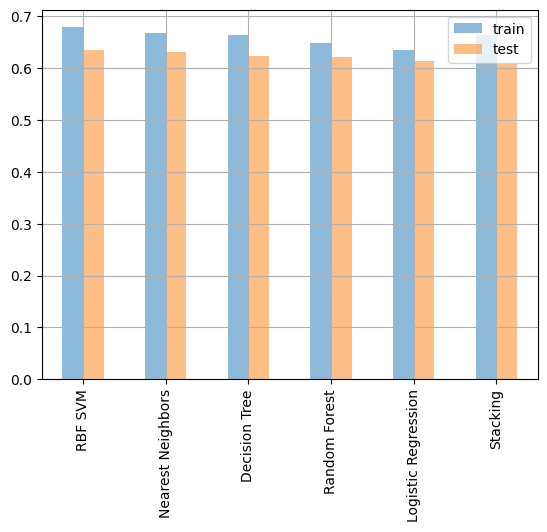

In [55]:
result_df.plot(kind='bar', alpha=0.5, grid=True)